In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import functools

import numpy as np
import scipy as sp
import ultraplot as uplt
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from folx import forward_laplacian

In [123]:
MU = 4

def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return 0.5 * jnp.sum((x-mu)**2) / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    # return _neg_log_like_gauss1d(x, 1)
    return jnp.sum(-5.0*x*x + x**4)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         -_neg_log_like_gauss1d(x, 0.25, mu=-MU) + jnp.log(0.25),
    #         -_neg_log_like_gauss1d(x, 1, mu=MU) + jnp.log(0.75),
    #     ])
    # )
    # s2pi = jnp.sqrt(2.0 * jnp.pi)
    # sigma = 0.25
    # val = 0.25 * jnp.exp(-0.5 * jnp.power((x + MU) / sigma, 2.0)) / sigma / s2pi
    # sigma = 1.0
    # val = val + 0.75 * jnp.exp(-0.5 * jnp.power((x - MU) / sigma, 2.0)) / sigma / s2pi
    # return -1.0 * jnp.log(jnp.sum(val))

flp_nll = forward_laplacian(_neg_log_like)

def _log_like(x):
    return -1.0 * _neg_log_like(x)

vmll = jax.vmap(_log_like)
vmnll = jax.vmap(_neg_log_like)
vmlapnll = jax.vmap(lambda x: jnp.sum(jnp.trace(jax.hessian(_neg_log_like)(jnp.array([x])))))


@functools.partial(jax.jit, static_argnames="fun")
def _value_and_grad_laplacian(x, fun):
    vandg = jax.value_and_grad(fun)(x)
    vandg_lap = jax.value_and_grad(lambda x: jnp.sum(jnp.trace(jax.hessian(fun)(x))))(x)
    return vandg[0], vandg[1], vandg_lap[0], vandg_lap[1]

@functools.partial(jax.jit, static_argnames="fun")
def _value_and_grad_forward_laplacian(x, fun):
    def _fun_for_grad_flp(x):
        res = forward_laplacian(fun)(x)
        return res.laplacian, res
    grad_lp, res = jax.jacfwd(_fun_for_grad_flp, has_aux=True)(x)
    return res.x, res.jacobian.dense_array, res.laplacian, grad_lp

@functools.partial(jax.jit, static_argnames="fun")
def _parlap(x, fun):
    x = x.reshape(-1)
    n = x.shape[0]
    eye = jnp.eye(n, dtype=x.dtype)
    value_and_grad_fun = jax.value_and_grad(fun)
    def grad_and_value_fun(x):
        return value_and_grad_fun(x)[::-1]
    jacobian, dgrad_fun, val = jax.linearize(grad_and_value_fun, x, has_aux=True)

    laplacian = jnp.sum(jnp.diagonal(jax.vmap(dgrad_fun)(eye)))
    return val, jacobian, laplacian

@functools.partial(jax.jit, static_argnames="fun")
def _value_and_grad_parlap(x, fun):
    def _fun_for_grad(x):
        res = _parlap(x, fun)
        return res[-1], res
    grad_lp, res = jax.grad(_fun_for_grad, has_aux=True)(x)
    return res[0], res[1], res[2], grad_lp

In [124]:
print(_value_and_grad_laplacian(jnp.array([-3.0]), _neg_log_like))
print(_value_and_grad_parlap(jnp.array([-3.0]), _neg_log_like))
print(_value_and_grad_forward_laplacian(jnp.array([-3.0]), _neg_log_like))


(Array(36., dtype=float64), Array([-78.], dtype=float64), Array(98., dtype=float64), Array([-72.], dtype=float64))
(Array(36., dtype=float64), Array([-78.], dtype=float64), Array(98., dtype=float64), Array([-72.], dtype=float64))
(Array(36., dtype=float64), Array([-78.], dtype=float64), Array(98., dtype=float64), Array([-72.], dtype=float64))


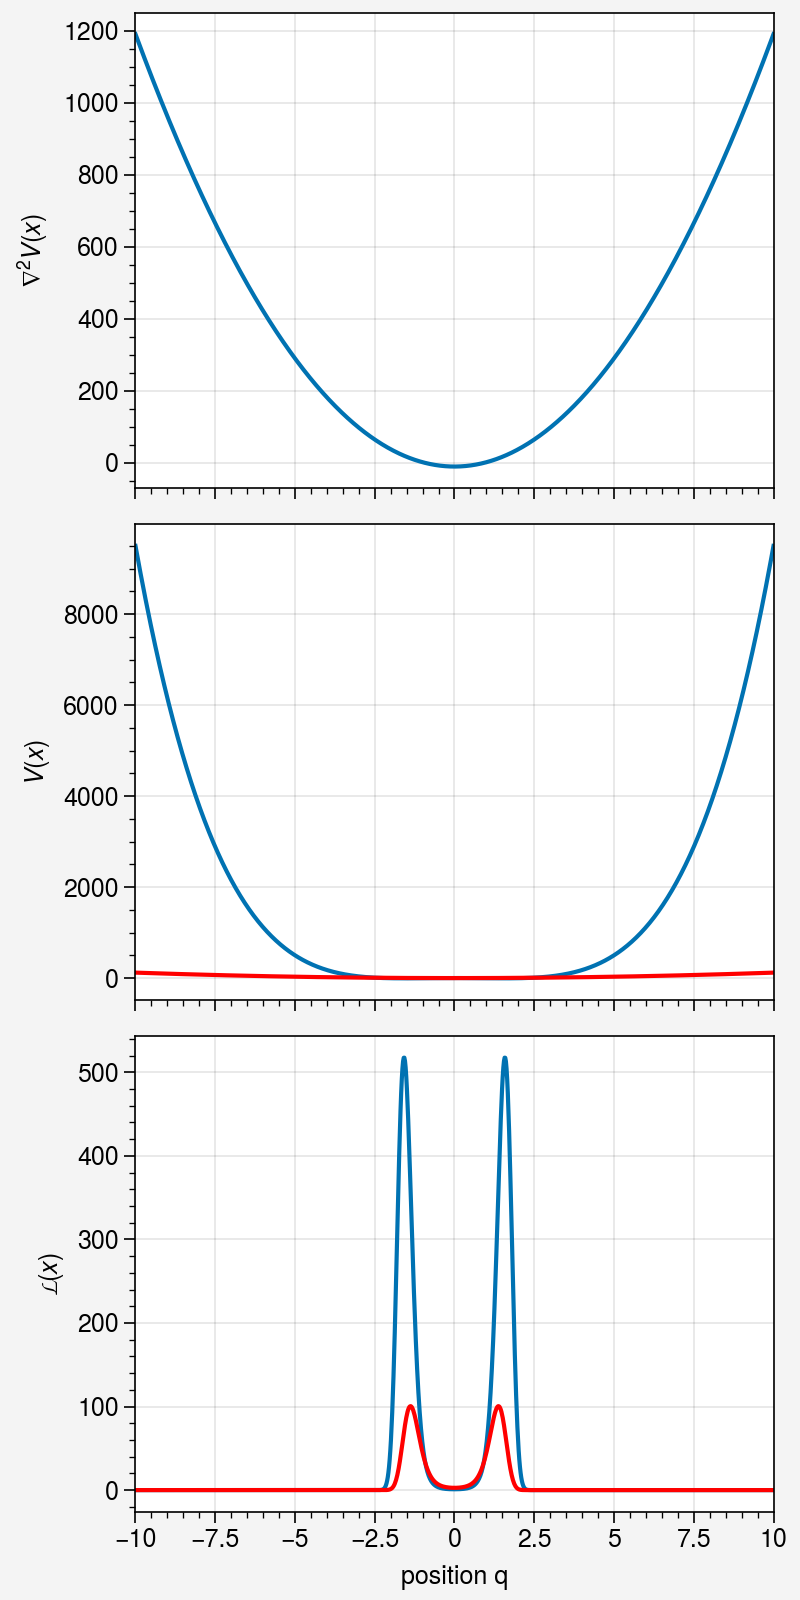

In [126]:
# β V[x]^(-2 + β) ((-1 + β) V'[x]^2 + V[x] V''[x])
x = jnp.linspace(-10, 10, 1000)
beta = 1
flpx = []
for _x in x:
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(jnp.array([_x]), _neg_log_like)
    # flpx.append(
    #     beta * jnp.power(v, beta - 2) * (
    #         v * lpv + (beta - 1) * gv*gv
    #     )
    # )
    # flpx.append(-(gv*gv - lpv) * jnp.exp(-v))
    #flpx.append(-1/(gv*gv + 1e1))
    flpx.append(lpv)
flpx = jnp.array(flpx).ravel()

# from scipy.ndimage import gaussian_filter1d
# flpx = gaussian_filter1d(flpx, sigma=1000/20 * 1)

def _weight(flpx, r=0.01, pr=2, hbar=0.001, d=1, m=1):
    logw = r / (2.0 * jnp.sqrt(d)) * (flpx) # + 4.0 / m * pr * pr + hbar*hbar*d/4/m/r/r)
    lognrm = jsp.special.logsumexp(logw)
    return jnp.exp(logw - lognrm)

_hbar = 1e-1

fig, axs = uplt.subplots(nrows=3, ncols=1, figsize=(4, 8), sharey=0, sharex=4)

tterm = flpx  # jnp.arcsinh(flpx) # jnp.sign(flpx) * jnp.power(jnp.abs(flpx), 0.1)

axs[0, 0].plot(x, tterm) # _weight(flpx) * x.shape[0])
axs[0, 0].format(xlabel="position q", ylabel=r"$\nabla^2 V(x)$")
axs[1, 0].plot(x, -vmll(x))
axs[1, 0].plot(x, _hbar * tterm, color="r")
axs[1, 0].format(xlabel="position q", ylabel=r"$V(x)$")
axs[2, 0].plot(x, jnp.exp(vmll(x)))
axs[2, 0].plot(x, jnp.exp(vmll(x) - _hbar * tterm), color="r")
axs[2, 0].format(xlabel="position q", ylabel=r"${\cal L}(x)$")


In [129]:
EPS = 0

@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _kick_c(q, p, b, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * gv
    return q, p, b, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _drift_c(q, p, b, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    return q, p, b, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _evolve_state_c(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_c(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _kick(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * (gv + r / 2 / jnp.sqrt(d) * glpv)
    rpe = r + EPS
    pr = pr - dt * (lpv / 2 / jnp.sqrt(d) - jnp.power(d, 1.5) * hbar * hbar / 8 / m / rpe / rpe)
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _drift(q, p, r, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    pr_fac = 1.0 + dt * 2.0 / m / jnp.sqrt(d) * pr
    r = r * pr_fac * pr_fac
    pr = pr / pr_fac

    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _evolve_state_symp(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr


def _kick_rc(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * (gv + r / 2 / jnp.sqrt(d) * glpv)
    # pr = pr - dt * (lpv / 2 / jnp.sqrt(d) - jnp.power(d, 1.5) * hbar * hbar / 8 / m / r / r)
    return q, p, r, pr


def _drift_rc(q, p, r, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    # pr_fac = 1.0 + dt * 2.0 / m / jnp.sqrt(d) * pr
    # r = r * pr_fac * pr_fac
    # pr = pr / pr_fac

    return q, p, r, pr


def _evolve_state_rc(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_rc(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_rc(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick_rc(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr

In [130]:
def _kd_q(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    sqrtd = jnp.sqrt(d)

    p = p - dt * (r / 2 / sqrtd * glpv)

    b = hbar * sqrtd / 2 / r
    c = 2 / sqrtd * pr + 1j * b
    alpha = -1.0 / sqrtd / 2.0 * lpv + 0j
    beta = 1.0 / m
    sqrt_a_b = jnp.sqrt(alpha) / jnp.sqrt(beta)
    sqrt_ab = jnp.sqrt(alpha) * jnp.sqrt(beta)
    c = sqrt_a_b * jnp.tanh(jnp.arctanh(c / sqrt_a_b) + dt * sqrt_ab)
    pr = jnp.real(c) * sqrtd / 2
    b = jnp.imag(c)
    r = hbar * sqrtd / 2 / b

    return q, p, b, pr


def _kd_q(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    sqrtd = jnp.sqrt(d)

    p = p - dt * (r / 2 / sqrtd * glpv)

    b = hbar * sqrtd / 2 / r
    c = 2 / sqrtd * pr + 1j * b
    alpha = 1.0 / sqrtd / 2.0 * lpv + 0j
    beta = 1.0 / m
    sqrt_a_b = jnp.sqrt(alpha) / jnp.sqrt(beta)
    sqrt_ab = jnp.sqrt(alpha) * jnp.sqrt(beta)
    c = sqrt_a_b * jnp.tan(jnp.arctan(c / sqrt_a_b) - dt * sqrt_ab)
    pr = jnp.real(c) * sqrtd / 2
    b = jnp.imag(c)
    r = hbar * sqrtd / 2 / b

    return q, p, r, pr


def _evolve_state_cq(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _kd_q(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _drift_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr

In [153]:
hbar = 1e-10
d = 1
m = 1
vfun = _neg_log_like

dt = 0.1 # * 9 / 8 # * 5 / 3 #* 4/3 # 2 /3 # * 3/2 # 2/3 #* 3/2
n_steps = 750

E0 = _neg_log_like(-MU)
dE = _neg_log_like(-MU+2)

q = 0.0
p = 10.0 # jnp.sqrt(2.0 * m *(dE - E0)) * 0.95
r = 1.0
# b = hbar * jnp.sqrt(d) / 2 / r
pr = 1.0

states = np.zeros((4, n_steps))
states[0, 0] = q
states[1, 0] = p
states[2, 0] = r
states[3, 0] = pr
states_c = np.zeros((2, n_steps))
states_c[0, 0] = q
states_c[1, 0] = p

ec = []
ec.append(jnp.ravel(p * p / 2 / m + _neg_log_like(q)))
eq = []
_, _, flpx, _ = _value_and_grad_forward_laplacian(jnp.array([q]), vfun)
# r = hbar * jnp.sqrt(d) / 2 / b
eq.append(jnp.ravel(
    1 / (2.0 * jnp.sqrt(d)) * (r*flpx + r*4.0 / m * pr * pr + hbar*hbar*d/4/m/(r + EPS))
))

for i in range(1, n_steps):
    q, p, r, pr = states[0, i-1:i], states[1, i-1:i], states[2, i-1:i], states[3, i-1:i]
    q, p, r, pr = _evolve_state_symp(q, p, r, pr, vfun, dt, d, hbar, m)
    states[0, i:i+1] = q
    states[1, i:i+1] = p
    states[2, i:i+1] = r
    states[3, i:i+1] = pr
    ec.append(jnp.ravel(p * p / 2 / m + _neg_log_like(q)))
    _, _, flpx, _ = _value_and_grad_forward_laplacian(q, vfun)
    # r = hbar * jnp.sqrt(d) / 2 / b
    eq.append(jnp.ravel(
        1 / (2.0 * jnp.sqrt(d)) * (r*flpx + r*4.0 / m * pr * pr + hbar*hbar*d/4/m/(r + EPS))
    ))

    q, p = states_c[0, i-1:i], states_c[1, i-1:i]
    q, p, _, _ = _evolve_state_c(q, p, r, pr, vfun, dt, d, hbar, m)
    states_c[0, i:i+1] = q
    states_c[1, i:i+1] = p

ec = jnp.array(ec)
eq = jnp.array(eq)


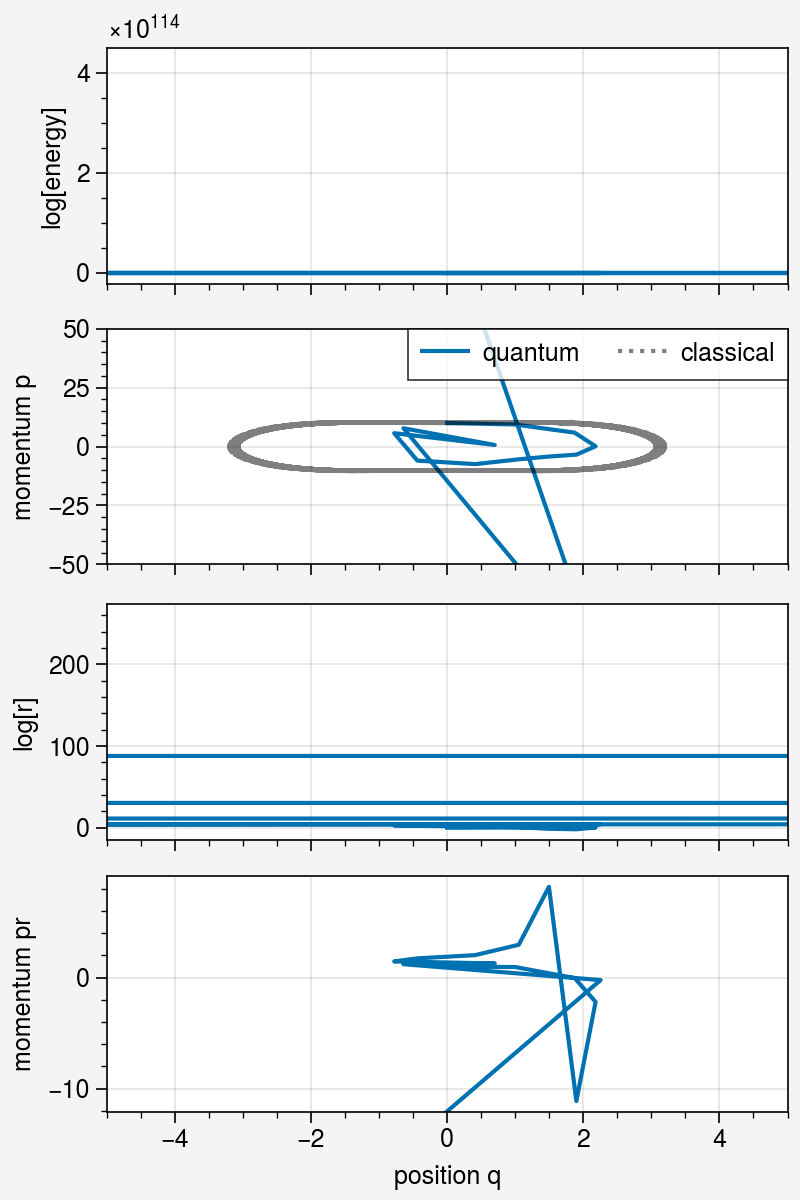

In [154]:
ns = 0
n = states.shape[1]

# fig, axs = uplt.subplots(nrows=2, ncols=1, sharey=0, figsize=(4, 6))

# xp = jnp.linspace(-10, 10, 1000)
# axs[0, 0].plot(xp, vmnll(xp) + r / 2.0 / jnp.sqrt(d) * vmlapnll(xp), label="quantum")
# axs[0, 0].plot(xp, vmnll(xp), color="k", label="classical")
# axs[0, 0].format(xlim=(-10, 10), ylabel="potential V(q)")

# axs[1, 0].plot(states[0, ns:n], states[1, ns:n], label="quantum")
# axs[1, 0].plot(states_c[0, ns:n], states_c[1, ns:n], color="k", label="classical")
# axs[1, 0].format(xlim=(-10, 10), ylim=(-50, 50), xlabel="position q", ylabel="momentum p")
# axs[1, 0].legend(loc="ur", frameon=False)

fig, axs = uplt.subplots(nrows=4, ncols=1, sharey=0, figsize=(4, 6))

# axs[0, 0].plot(states[0, ns:n], np.log(ec[ns:n]))
# axs[0, 0].plot(states[0, ns:n], np.log(eq[ns:n]), color="red", linestyle="dotted")
axs[0, 0].plot(states[0, ns:n], eq[ns:n] + ec[ns:n]) #, color="green", linestyle="dashed")
# axs[0, 0].axhline(np.log(dE), color="k")
axs[0, 0].format(xlabel="position q", ylabel="log[energy]")

axs[1, 0].plot(states[0, ns:n], states[1, ns:n], label="quantum")
axs[1, 0].plot(states_c[0, ns:n], states_c[1, ns:n], color="k", linestyle="dotted", alpha=0.5, label="classical")
axs[1, 0].format(ylim=(-50, 50), xlabel="position q", ylabel="momentum p")
axs[1, 0].legend(loc="ur")

axs[2, 0].plot(states[0, ns:n], jnp.log(states[2, ns:n]))
axs[2, 0].format(xlim=(-10, 10), xlabel="position q", ylabel="log[r]")

axs[3, 0].plot(states[0, ns:n], states[3, ns:n])
axs[3, 0].format(xlim=(-5, 5), xlabel="position q", ylabel="momentum pr")

# fig, axs = uplt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharey=0, sharex=4)
# axs[0, 0].plot(jnp.log(eq+ec)[ns:n])
# axs[1, 0].plot(jnp.log(states[2, ns:n]))
# axs[2, 0].plot(states[1, ns:n])
# axs[2, 0].format(ylim=(-50, 50))
# axs[3, 0].plot(states[0, ns:n])
# axs[3, 0].format(ylim=(-10, 10))

In [193]:
np.log(ec[0])

array([3.3773788])

<a list of 1 Line2D objects>

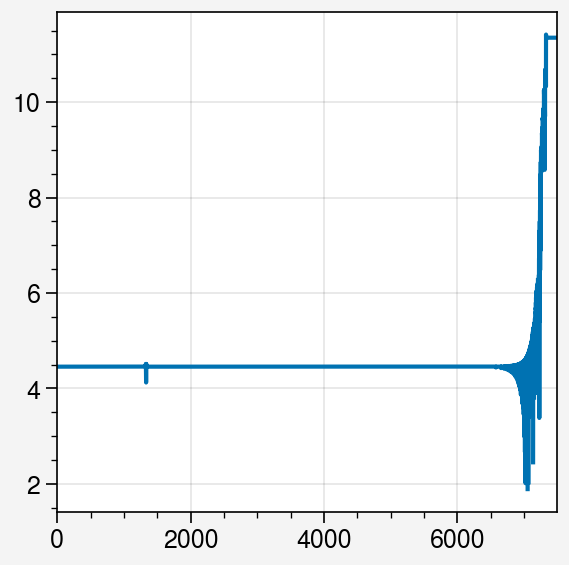

<a list of 1 Line2D objects>

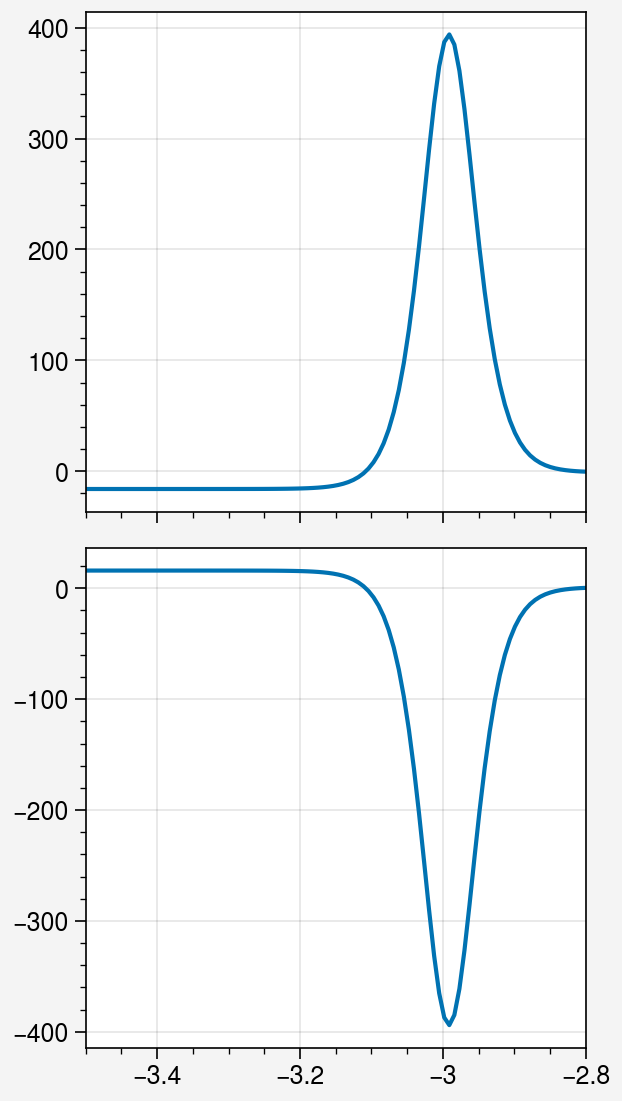

In [132]:

def _f(x):
    s2pi = jnp.sqrt(2.0 * jnp.pi)
    sigma = 0.25
    mu = -5.0
    return jnp.sum(0.25 * jnp.exp(-0.5 * jnp.power((x - mu) / sigma, 2.0)) / sigma / s2pi)

def _g(x):
    s2pi = jnp.sqrt(2.0 * jnp.pi)
    sigma = 1
    mu = 5.0
    return jnp.sum(0.75 * jnp.exp(-0.5 * jnp.power((x - mu) / sigma, 2.0)) / sigma / s2pi)

_gf = jax.grad(_f)
_ggf = jax.grad(_gf)

_gg = jax.grad(_g)
_ggg = jax.grad(_gg)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    # return _neg_log_like_gauss1d(x, 1)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         -_neg_log_like_gauss1d(x, 0.25, mu=-MU) + jnp.log(0.25),
    #         -_neg_log_like_gauss1d(x, 1, mu=MU) + jnp.log(0.75),
    #     ])
    # )
    return -1.0 * jnp.log(_f(x) + _g(x))

@jax.jit
def _lap_auto(x):
    return jnp.sum(jnp.trace(jax.hessian(_neg_log_like)(x)))

@jax.jit
def _lap_expr(x):
    fpg = _f(x) + _g(x)
    _gfpg = _gf(x) + _gg(x)
    _ggfpg = _ggf(x) + _ggg(x)

    # print((fpg*_ggfpg - _gfpg*_gfpg), fpg**2)
    return (fpg*_ggfpg - _gfpg*_gfpg) / fpg / fpg

x = jnp.linspace(-3.5, -2.8, 100)
lapex = []
lapau = []
for _x in x:
    lapex.append(_lap_expr(_x))
    lapau.append(_lap_auto(jnp.array([_x])))
lapex = jnp.array(lapex)
lapau = jnp.array(lapau)

fig, axs = uplt.subplots(nrows=2, ncols=1)

axs[0, 0].plot(x, lapex)
axs[1, 0].plot(x, lapau)